<a href="https://colab.research.google.com/github/josephxlp/FinMLA/blob/main/Stock_Sentiment_Analysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!pip install nltk gensim transformers datasets --q

In [101]:
from google.colab import drive
from pathlib import Path
import os
import re
import pickle
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [102]:
# data preparation
def remove_punctuation_from_text(text): #
  txt_prox = [char for char in text if char not in string.punctuation]
  txt_join = ''.join(txt_prox)
  return txt_join

def remove_stopwords(text):
  out = []
  for token in gensim.utils.simple_preprocess(text):
    if len(token) >= 2 and token not in stop_words and token not in gensim.parsing.preprocessing.STOPWORDS:
      out.append(token)
  return out

def nltk_stopwords_setup(stopwords_lang=None,
                         extra_stopwords=None):
  nltk.download("stopwords") #
  if stopwords_lang is None:
    stopwords_lang = 'english'
  if extra_stopwords is None:
    extra_stopwords = ['from', 'subject', 're', 'edu', 'use','will','aap','co',
                       'day','user','stock','today','week','year','http','www']

  stop_words = stopwords.words(stopwords_lang)
  stop_words.extend(extra_stopwords)
  return stop_words

def nltk_punctuation_setup():
  nltk.download('punkt')

def get_total_nunique_words(df,name='gensim_text'):
    # Obtain the total words present in the dataset
  list_of_words = []
  for i in df[name]:
    for j in i:
          list_of_words.append(j)

  # Obtain the total number of unique words
  total_words = len(list(set(list_of_words)))
  return total_words,list_of_words

def pipeline_prepare_data(df):
  stop_words = nltk_stopwords_setup()
  nltk_punctuation_setup()
  df['string_text'] = df['text'].apply(remove_punctuation_from_text)
  df['gensim_text'] = df['string_text'].apply(remove_stopwords)
  df['gensim_text_join'] = df['gensim_text'].apply(lambda x: " ".join(x))
  df['text_length'] = [ len(nltk.word_tokenize(x)) for x in df['gensim_text_join']]
  total_words,list_of_words = get_total_nunique_words(df, name='gensim_text')
  return df, total_words,list_of_words

In [103]:
# ML data preprocessing
def split_data(X, y, test_size=0.1, val_size=0.1, random_state=42):
  """
  Splits the dataset into training, validation, and test sets.

  Parameters:
  - X: Features dataset.
  - y: Target labels.
  - test_size: Proportion of the dataset to include in the test split.
  - val_size: Proportion of the training dataset to include in the validation split.
  - random_state: Controls the shuffling applied to the data before applying the split.

  Returns:
  - X_train: Training features.
  - X_val: Validation features.
  - X_test: Test features.
  - y_train: Training labels.
  - y_val: Validation labels.
  - y_test: Test labels.
  """
  # First split into train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Calculate the validation size relative to the new training set
  val_relative_size = val_size / (1 - test_size)

  # Split the training set into train and validation
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_relative_size, random_state=random_state)

  return X_train, X_val, X_test, y_train, y_val, y_test

def save_tokenizer(tokenizer, file_path='tokenizer.pkl'):
  """
  Saves a fitted tokenizer to a specified file using pickle.

  Parameters:
  - tokenizer: The fitted Keras Tokenizer object.
  - file_path: The path where the tokenizer should be saved.
  """
  with open(file_path, 'wb') as file:
      pickle.dump(tokenizer, file)
  print(f"Tokenizer saved to {file_path}")


def load_tokenizer(file_path):
  """
  Loads a tokenizer from a specified pickle file.

  Parameters:
  - file_path: The path to the pickle file containing the saved tokenizer.

  Returns:
  - The loaded Keras Tokenizer object.
  """
  with open(file_path, 'rb') as file:
      tokenizer = pickle.load(file)
  print(f"Tokenizer loaded from {file_path}")
  return tokenizer

def preprocess_XY_text_data(total_words, X, Y, nclass=2, maxlen=29, tokenizer_path='tokenizer.pkl', mode='train'):
  # Check if tokenizer exists
  if tokenizer_path and os.path.exists(tokenizer_path):
      tokenizer = load_tokenizer(tokenizer_path)
  else:
      tokenizer = Tokenizer(num_words=total_words)
      tokenizer.fit_on_texts(X)
      save_tokenizer(tokenizer, tokenizer_path)

  X_sequences = tokenizer.texts_to_sequences(X)

  if mode == 'train':
      X_pad = pad_sequences(X_sequences, maxlen=maxlen, padding='post', truncating='post')
  else:
      X_pad = pad_sequences(X_sequences, maxlen=maxlen, padding='post')

  Ycat = to_categorical(Y, nclass)
  return X_pad, Ycat

def create_model(total_words):
  model = Sequential()
  model.add(Embedding(total_words, output_dim=512))
  model.add(LSTM(256))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model

def prediction2d_to_vector(prediction2d):
  assert prediction2d.shape[1] == nclass, 'invalid format, prediction should have nclass dim'
  prediction = []
  for i in prediction2d:
    prediction.append(np.argmax(i))
  return prediction

In [104]:
def classification_report_df(y_true, y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Define meanings based on scores
  def interpret_score(score):
      if score >= 0.9:
          return "Excellent"
      elif score >= 0.8:
          return "Very Good"
      elif score >= 0.7:
          return "Good"
      elif score >= 0.6:
          return "Fair"
      else:
          return "Poor"

  # Create a DataFrame
  report_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1],
      'Meaning': [interpret_score(accuracy), interpret_score(precision),
                  interpret_score(recall), interpret_score(f1)]
  })

  # Plot confusion matrix
  fig = plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['Actual Negative', 'Actual Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Interpretation of the confusion matrix
  tn, fp, fn, tp = conf_matrix.ravel()
  interpretation_text = (
      f"True Positives (TP): {tp} - Correctly predicted positive cases.\n"
      f"True Negatives (TN): {tn} - Correctly predicted negative cases.\n"
      f"False Positives (FP): {fp} - Incorrectly predicted as positive (Type I error).\n"
      f"False Negatives (FN): {fn} - Incorrectly predicted as negative (Type II error).\n\n"
      f"**Metrics Relationship:**\n"
      f"- **Precision** (TP / (TP + FP)): Measures the accuracy of positive predictions. High precision indicates a low false positive rate.\n"
      f"- **Recall** (TP / (TP + FN)): Measures the ability to find all positive samples. High recall indicates a low false negative rate.\n"
      f"- **Accuracy** ((TP + TN) / Total): Overall correctness of the model. It can be misleading if classes are imbalanced.\n"
      f"- **F1 Score**: Harmonic mean of precision and recall, useful for imbalanced classes.\n\n"
      f"**Improvement Suggestions:**\n"
      f"To improve the model, focus on increasing precision and recall by reducing FP and FN. This can be achieved by tuning the model, using more data, or selecting better features."
  )
  print("Interpretation of Confusion Matrix:")
  print(interpretation_text)

  conf_matrix_df = pd.DataFrame(conf_matrix,
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

  return report_df, conf_matrix_df, fig

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [105]:
rootpath = Path("/content/drive/MyDrive/portfolio/FinMLA")
datapath = rootpath / 'data'

In [106]:
stock_sentiment_df = pd.read_csv(datapath/"stock_sentiment.csv")

In [107]:
df = stock_sentiment_df.copy()

In [108]:
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [45]:
df.columns = ['text','sentiment']

In [46]:
df.sentiment.value_counts()

,count
sentiment,
1,3685
0,2106


In [47]:
df.isna().sum()

,0
text,0
sentiment,0


In [ ]:
fcol ='gensim_text'
tcol ='sentiment'
nclass = 2
stop_words = nltk_stopwords_setup()
nltk_punctuation_setup()
df, total_words,list_of_words = pipeline_prepare_data(df)
trainx, validx, testx, trainy, validy, testy = split_data(df[fcol],df[tcol])

In [16]:
df.sample(1).values

array([['First trade coming back from vacation. HOT short at 59.80. Stop at 60.30',
        0,
        'First trade coming back from vacation HOT short at 5980 Stop at 6030']],
      dtype=object)

In [19]:
df.sample(1).values.tolist()

[['3 tech stocks with staying power - IBM, Intel INTC & Qualcomm QCOM. And QCOM lets you keep AAP exposure to boot!  ',
  1,
  '3 tech stocks with staying power  IBM Intel INTC  Qualcomm QCOM And QCOM lets you keep AAP exposure to boot  ',
  ['tech',
   'stocks',
   'staying',
   'power',
   'ibm',
   'intel',
   'intc',
   'qualcomm',
   'qcom',
   'qcom',
   'lets',
   'exposure',
   'boot']]]

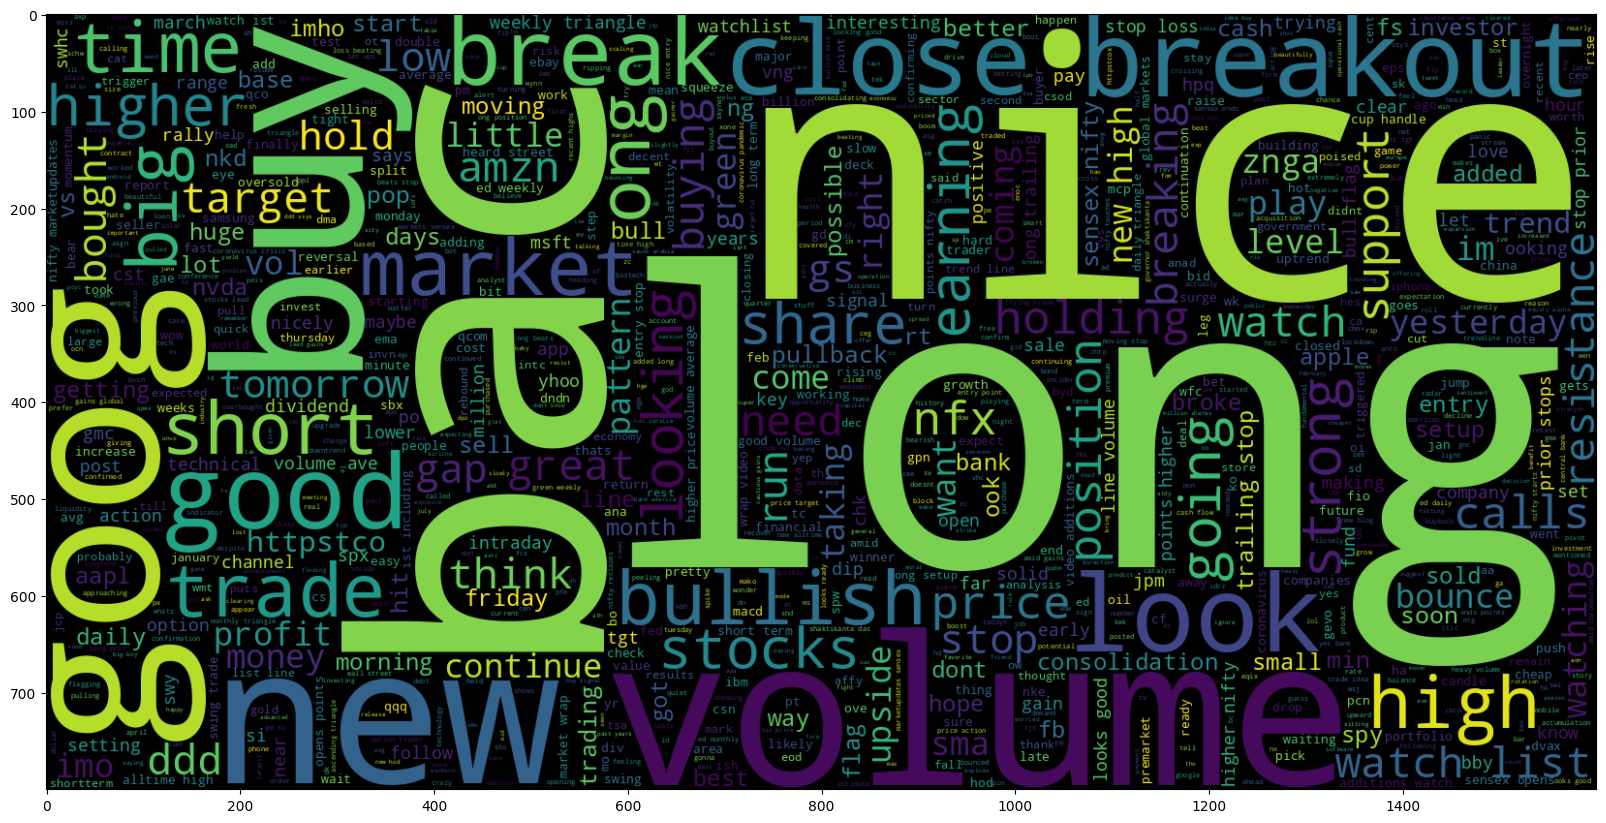

In [22]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df[df['sentiment'] == 1]['gensim_text_join']))
plt.imshow(wc, interpolation = 'bilinear');

In [26]:
# word_tokenize is used to break up a string into words
print(df['gensim_text_join'][0])
print(nltk.word_tokenize(df['gensim_text_join'][0]))

kickers watchlist xide tit soq pnk cpw bpz aj trade method method prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', 'method', 'prev', 'posts']


In [27]:
# Obtain the maximum length of data in the document
# This will be later used when word embeddings are generated
maxlen = -1
for doc in df['gensim_text_join']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 22


In [28]:
df['text_length'] = [ len(nltk.word_tokenize(x)) for x in df['gensim_text_join']]
df.head(4)

,text,sentiment,string_text,gensim_text,gensim_text_join,text_length
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...,14
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome,6
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...,8
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta,1


In [29]:
fig = px.histogram(x = df['text_length'].tolist(), nbins = 50)
fig.show()

In [38]:
trainx_pad, trainy_cat = preprocess_XY_text_data(total_words,trainx, trainy)
validx_pad, validy_cat = preprocess_XY_text_data(total_words,validx, validy,mode=None)

Tokenizer loaded from tokenizer.pkl
Tokenizer loaded from tokenizer.pkl


In [40]:
model = create_model(total_words)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
trainx_pad.shape, trainy_cat.shape,validx_pad.shape, validy_cat.shape

((4632, 29), (4632, 2), (579, 29), (579, 2))

In [109]:
#baseline model
Nepoch = 5
BatchS = 32
csv_logger = CSVLogger('training_history.csv')
#lr_callback

In [59]:
history = model.fit(
      trainx_pad, trainy_cat,
      validation_data=(validx_pad, validy_cat),
      epochs=Nepoch,
      batch_size=BatchS,
      callbacks=[csv_logger]#lr_callback
  )


Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 287ms/step - acc: 0.6420 - loss: 0.6621 - val_acc: 0.6235 - val_loss: 0.6616
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - acc: 0.6873 - loss: 0.6010 - val_acc: 0.6235 - val_loss: 0.6543
Epoch 3/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - acc: 0.7126 - loss: 0.5548 - val_acc: 0.7565 - val_loss: 0.5425
Epoch 4/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - acc: 0.8273 - loss: 0.4532 - val_acc: 0.7547 - val_loss: 0.5405
Epoch 5/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - acc: 0.8387 - loss: 0.4393 - val_acc: 0.7496 - val_loss: 0.5820


In [110]:

final_metrics = model.evaluate(validx_pad, validy_cat, verbose=0)

In [111]:
log_data = {
      'batch_size': BatchS,
      'epochs': Nepoch,
      #'learning_rate': learning_rate,
      'final_loss': final_metrics[0],
      'final_accuracy': final_metrics[1]
  }

with open('training_log.json', 'w') as f:
    json.dump(log_data, f)

In [112]:
log_data

{'batch_size': 32,
 'epochs': 5,
 'final_loss': 0.5820013880729675,
 'final_accuracy': 0.7495682239532471}

In [113]:
testx_pad, testy_cat = preprocess_XY_text_data(total_words,testx, testy,mode=None)

Tokenizer loaded from tokenizer.pkl


In [114]:
testp_ = model.predict(testx_pad)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [115]:
assert testp_.shape[1] == nclass, 'invalid format'

In [116]:
testp = prediction2d_to_vector(testp_)
len(testp)

580

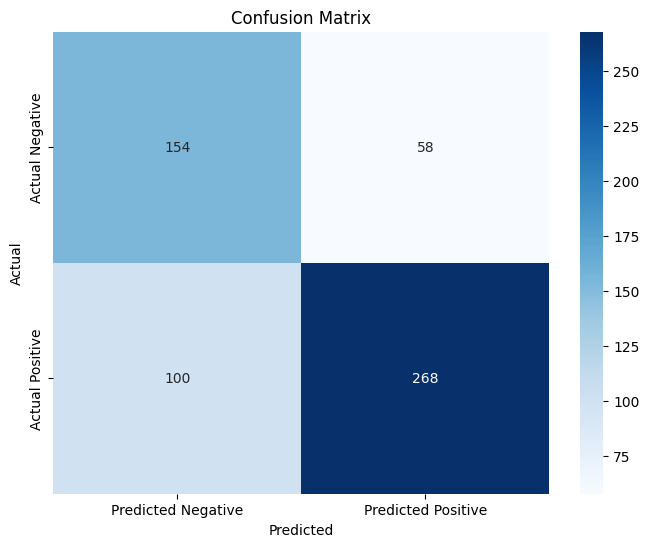

Interpretation of Confusion Matrix:
True Positives (TP): 268 - Correctly predicted positive cases.
True Negatives (TN): 154 - Correctly predicted negative cases.
False Positives (FP): 58 - Incorrectly predicted as positive (Type I error).
False Negatives (FN): 100 - Incorrectly predicted as negative (Type II error).

**Metrics Relationship:**
- **Precision** (TP / (TP + FP)): Measures the accuracy of positive predictions. High precision indicates a low false positive rate.
- **Recall** (TP / (TP + FN)): Measures the ability to find all positive samples. High recall indicates a low false negative rate.
- **Accuracy** ((TP + TN) / Total): Overall correctness of the model. It can be misleading if classes are imbalanced.
- **F1 Score**: Harmonic mean of precision and recall, useful for imbalanced classes.

**Improvement Suggestions:**
To improve the model, focus on increasing precision and recall by reducing FP and FN. This can be achieved by tuning the model, using more data, or selecting

In [117]:
report_df, cm_df,cm_fig = classification_report_df(testy,testp)

Next step: Use Transformers

In [80]:
from transformers import pipeline

In [81]:
nlp = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [86]:
df.sample(10).values

array([['user: user no, P lol Vapour~ware. one strong breeze and it is gone IMHO',
        1],
       ['its time to put GOOG under the warming lamp and get some heat into it, just languishing for now  ',
        1],
       ['AJ Over 18.00 on good volume   ', 1],
       ['user AMZN holding above the 50dma in a diamond pattern. ooks good for higher prices...imo  ',
        1],
       ['SHD - Appearance of a 180 Bullish Cup and Handle. Someone has put on a SPD.  ',
        1],
       ['seller stepped down to 89.25 in vmw.', 0],
       ['ISG this technology is still in its infancy...the demand is there.  Hospitals/surgeons want it.  Will only get better over time imo.',
        1],
       ['SWY Option Bears buy puts betting 500k on over 10% down move  ',
        0],
       ['AAP 435 retest and now probably 420', 0],
       ['user: AAP, #NYTimes, #WSJ, #EndGadget, #Gizmodo give #Galaxy S4 thumbs down who da thunk samsung down 2.5% on release today',
        1]], dtype=object)